# Implementing a reparameterized Gamma sampler
@fritzo 2017-11-26

This notebook derives the `standard_gamma_grad(x,alpha)` function that is used to compute reparameterized gradients in `torch.distributions.Gamma().sample()`.

In [1]:
import torch
from torch.autograd import Variable
import numbers
import numpy as np
import scipy.stats
import scipy.optimize
from matplotlib import pyplot
%matplotlib inline

In [2]:
from torch.distributions import Gamma, Normal

In [3]:
def set_seed(seed=0):
    torch.manual_seed(seed)
    np.random.seed(seed)

First, let's use SciPy to compute the desired reparameterized gradient for given (x, alpha). This is based on the following definition. Let $x\sim \Gamma(\alpha)$ be a standard Gamma random variable. The the reparameterized gradient is 
$$
 \frac {dx}{d\alpha} = -\frac{\frac d{d\alpha}cdf(x;\alpha)}
                             {\frac d{dx}cdf(x;\alpha)}
                     = -\frac{\frac d{d\alpha}cdf(x;\alpha)}{pdf(x;\alpha)}
$$

In [4]:
def dx_dalpha(x, alpha):
    """
    Computes finite-difference approximation of the reparameterized gradient dx/dalpha.
    """
    cdf = scipy.stats.gamma.cdf
    pdf = scipy.stats.gamma.pdf
    # eps = scipy.stats.gamma.var(alpha) ** 0.5 * 0.01
    if isinstance(alpha, numbers.Number):
        alpha = np.array([alpha])
    eps = alpha * 0.02
    eps[alpha > 10] = alpha[alpha > 10] ** 0.5 * 0.02
    d_dalpha = (cdf(x, alpha + eps) - cdf(x, alpha - eps)) / (2 * eps)
    d_dx = pdf(x, alpha)
    return -d_dalpha / d_dx

What this computes is the rate of change in x as alpha is varied and a horizontal line is fixed, cutting through cdf() values:

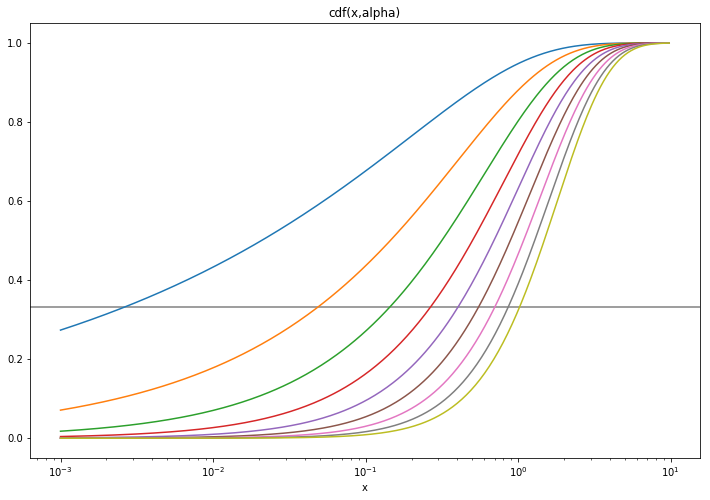

In [5]:
pyplot.figure(figsize=(12,8))
y = 10 ** np.arange(-3, 1, 0.01)
pyplot.axhline(0.333, color='gray')
for alpha in np.arange(0.2, 2, 0.2):
    pyplot.plot(y, scipy.stats.gamma.cdf(y, alpha))
pyplot.xscale('log')
pyplot.title('cdf(x,alpha)')
pyplot.xlabel('x')
pyplot.show()

Jumping ahead, let's see how our approximation works on randomly drawn samples for various `alpha` values between 0.0001 and 10000 (this uses the torch implementation):

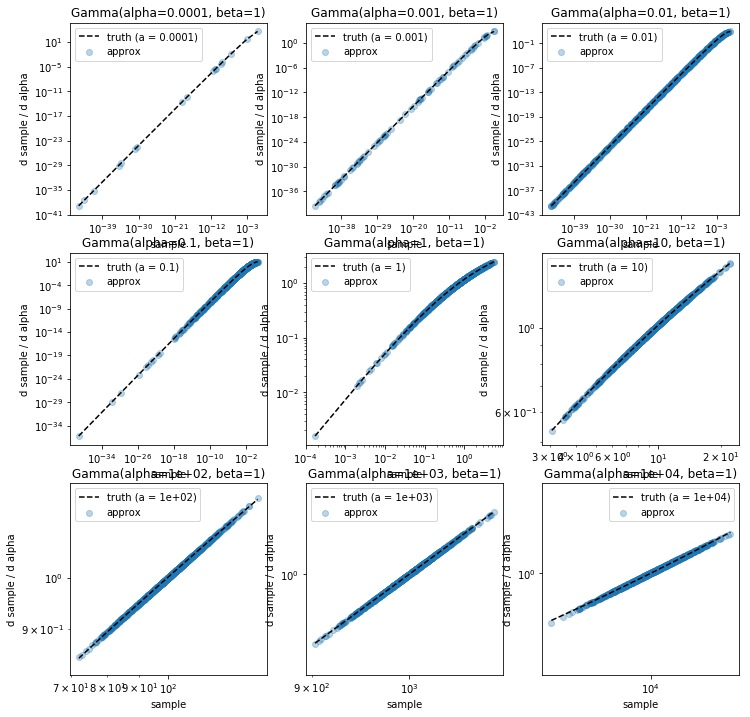

In [6]:
set_seed(0)
alpha = 29
num_samples = 1000
fig, axes = pyplot.subplots(3, 3, figsize=(12,12))
alpha_grid = np.array([1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4])
for ax, alpha in zip(axes.reshape(-1), alpha_grid):
    alphas = Variable(alpha * torch.ones(num_samples), requires_grad=True)
    betas = Variable(torch.ones(alphas.size()))
    x = Gamma(alphas, betas).sample()
    x.sum().backward()
    x, ind = x.data.sort()
    x = x.numpy()
    actual_grad = alphas.grad.data[ind].numpy()
    alphas = alphas.data[ind].numpy()
    ax.scatter(x, actual_grad, alpha=0.3, label='approx')
    ax.plot(x, dx_dalpha(x, alpha), 'k--', label='truth (a = {:0.2g})'.format(alpha))
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title('Gamma(alpha={:0.2g}, beta=1)'.format(alpha))
    ax.set_xlabel('sample')
    ax.set_ylabel('d sample / d alpha')
    ax.legend()
pyplot.show()

## Benchmarks

And let's see how expensive the approximation is. It's actually cheaper than the forward sampler.

In [7]:
n = 10
dist = Gamma(Variable(torch.ones(n, 1000, 1000) * 0.9, requires_grad=True),
             Variable(torch.ones(n, 1000, 1000), requires_grad=True))
print('---- Forward ----')
%time x = dist.sample()
print('---- Backward ----')
%time x.sum().backward()

---- Forward ----
CPU times: user 946 ms, sys: 35.1 ms, total: 981 ms
Wall time: 985 ms
---- Backward ----
CPU times: user 665 ms, sys: 109 ms, total: 775 ms
Wall time: 777 ms


Here's a Normal distribution for comparison.

In [8]:
n = 10
dist = Normal(Variable(torch.ones(n, 1000, 1000), requires_grad=True),
              Variable(torch.ones(n, 1000, 1000), requires_grad=True))
print('---- Forward ----')
%time x = dist.sample()
# %time x = dist.sample(requires_grad=True)
# print('---- Backward ----')
# %time x.sum().backward()

---- Forward ----
CPU times: user 480 ms, sys: 33.7 ms, total: 514 ms
Wall time: 431 ms


## Approximating the reparameterized gradient

Now let's derive the approximation. Recall the shape of `cdf(x, alpha)` that we want to approximate.

/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


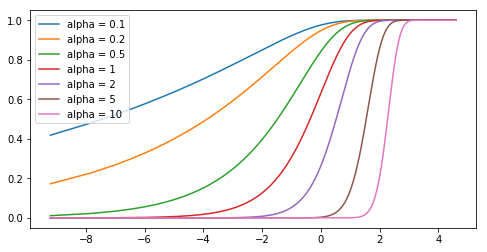

In [9]:
x = np.arange(0, 10, 0.01) ** 2
pyplot.figure(figsize=(8, 4))
for alpha in [0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0]:
    pyplot.plot(np.log(x), scipy.stats.gamma.cdf(x, alpha), label='alpha = {:0.2g}'.format(alpha))
pyplot.legend()
pyplot.show()

Following [Knowles (2015)](https://arxiv.org/pdf/1509.01631.pdf), we first approximate `dx_dalpha()` by two asymptotes:
1. For $\alpha << 1$, we differentiate $icdf(z;\alpha) \approx (z\alpha\Gamma(\alpha))^{\frac 1 \alpha}$
2. For $\alpha >> 1$ (e.g. > 1000), we use the Gaussian approximation $\mathcal N(\alpha, \sigma=\alpha)$, whereby the reparameterized gradient is $\nabla_\alpha x = 1 + x\alpha^\frac{-1}2$. An even better approximation is $\nabla_\alpha x = \sqrt{x/\alpha}$; this works well down to $\alpha > 30$.

In [10]:
def dx_dalpha_small_v1(x, alpha):
    return -x / alpha * (np.log(x) - 1.0 / alpha - scipy.special.digamma(alpha))
def dx_dalpha_small_v2(x, alpha):
    gamma_pdf = x**(alpha-1) * np.exp(-x)
    gamma_cdf = x**alpha * (1/alpha - x/(alpha+1) + 0.5*x**2/(alpha+2))
    gamma_cdf_alpha = -scipy.special.digamma(alpha) * gamma_cdf \
        + x**alpha * np.log(x) * (1/alpha - x/(alpha+1) + 0.5*x**2/(alpha+2)**2) \
        - x**alpha * (1/alpha**2 - x/(alpha+1)**2 + 0.5*x**2/(alpha+2)**2)
    return -gamma_cdf_alpha / gamma_pdf
def dx_dalpha_small_valid(x, alpha):
    return x < 0.2
dx_dalpha_small = dx_dalpha_small_v2

def dx_dalpha_large(x, alpha):
    return (x / alpha) ** 0.5
def dx_dalpha_large_valid(x, alpha):
    return alpha > 50.0

In [11]:
LB, UB = 1e-5, 1e3
alphas = LB * (UB / LB) ** np.random.random(100000)
xs = scipy.stats.gamma.rvs(alphas)
truth = dx_dalpha(xs, alphas)
approximations = [
    ('small1', dx_dalpha_small_v1, dx_dalpha_small_valid),
    ('small2', dx_dalpha_small_v2, dx_dalpha_small_valid),
    ('large', dx_dalpha_large, dx_dalpha_large_valid),
]
print('\t'.join(['version', 'max_err', 'rms_err',
                 'alpha', 'x', 'truth', 'approx', 'volume']))
print('-' * 8 * 8)
for name, approx_fn, is_valid in approximations:
    w = is_valid(xs, alphas) & (truth > 0)
    approx = approx_fn(xs[w], alphas[w])
    error = np.abs(approx - truth[w]) / (1e-10 + truth[w])
    i = np.argmax(error)
    print('{}\t{:0.2g}\t{:0.2g}\t{:0.2g}\t{:0.2g}\t{:0.2g}\t{:0.2g}\t{:0.2g}'.format(
        name, error.max(), (error**2).mean()**0.5,
        alphas[w][i], xs[w][i], truth[w][i], approx[i], w.mean()))

version	max_err	rms_err	alpha	x	truth	approx	volume
----------------------------------------------------------------
small1	0.3	0.038	0.0017	0.19	1.7e+02	1.2e+02	0.33
small2	0.0071	0.00041	2.4	0.035	0.067	0.066	0.33
large	0.0058	0.0011	54	33	0.78	0.79	0.16


/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/scipy/stats/_continuous_distns.py:2329: RuntimeWarning: overflow encountered in exp
  return np.exp(self._logpdf(x, a))
/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in power
  after removing the cwd from sys.path.


Let's see how closely these approximations match some example samples:

/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in power
  after removing the cwd from sys.path.
/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in power
  after removing the cwd from sys.path.
/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered

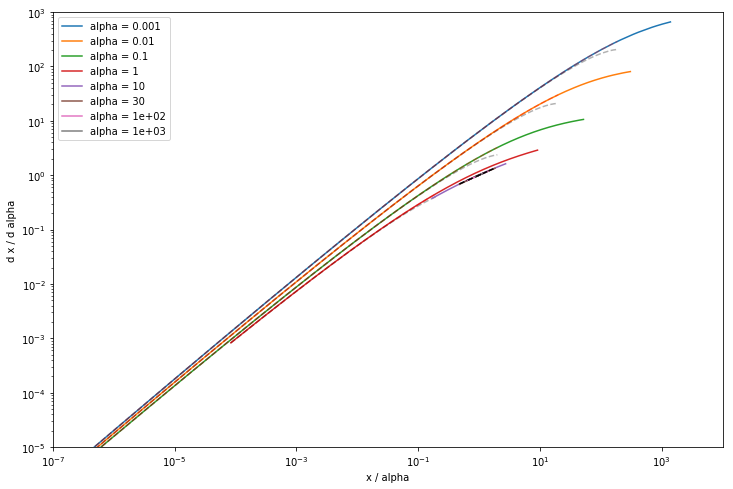

In [12]:
pyplot.figure(figsize=(12, 8))
for alpha in [0.001, 0.01, 0.1, 1.0, 10.0, 30.0, 100.0, 1000.0]:
    x = scipy.stats.gamma.rvs(np.ones(10000) * alpha)
    x.sort()
    u = x / alpha
    pyplot.plot(u, dx_dalpha(x, alpha), label='alpha = {:0.2g}'.format(alpha))
    w = dx_dalpha_small_valid(x, alpha)
    pyplot.plot(u[w], dx_dalpha_small_v1(x[w], alpha), 'k--', alpha=0.3)
    pyplot.plot(u[w], dx_dalpha_small_v2(x[w], alpha), 'r--', alpha=0.3)
    if alpha >= 30:
        pyplot.plot(u, dx_dalpha_large(x, alpha), 'k--')
pyplot.ylabel('d x / d alpha')
pyplot.xlabel('x / alpha')
pyplot.xscale('log')
pyplot.yscale('log')
pyplot.xlim(0.0000001, 10000)
pyplot.ylim(0.00001, 1000)
pyplot.legend()
pyplot.show()

Let's approximate using a bivariate rational function of $\log(x/\alpha)$ and $\log(\alpha)$.

In [13]:
def dx_dalpha_approx(x, alpha, coeff):
    coeff = coeff.reshape((3, 8)).copy()
    coeff[0, 4] = 1
    u = np.log(x / alpha)
    v = np.log(alpha)
    c = [
        cs[0] + u * (cs[1] + u * cs[2])
        for cs in coeff.T
    ]
    p = c[0] + v * (c[1] + v * (c[2] + v * c[3]))
    q = c[4] + v * (c[5] + v * (c[6] + v * c[7]))
    return np.exp(p / np.maximum(q, 1e-2))

In [14]:
np.random.seed(0)
LB, UB = 1e-5, 1e2
alpha_train = np.exp(np.random.random(100000) * (np.log(UB) - np.log(LB)) + np.log(LB))
alpha_train.sort()
x_train = scipy.stats.gamma.rvs(alpha_train)
print('alpha = [{:0.5g}, {:0.5g}, ..., {:0.5g}, {:0.5g}]'.format(
    alpha_train[0], alpha_train[1], alpha_train[-2], alpha_train[-1]))
valid = ~dx_dalpha_small_valid(x_train, alpha_train) & (x_train < UB * 4)
alpha_train = alpha_train[valid]
x_train = x_train[valid]
grad_train = dx_dalpha(x_train, alpha_train)
print(len(grad_train))

alpha = [1.0001e-05, 1.0009e-05, ..., 99.949, 99.964]
34722


In [15]:
def approx_objective(coeff):
    x = x_train
    alpha = alpha_train
    approx = dx_dalpha_approx(x, alpha, coeff).reshape(-1)
    error = np.empty(len(approx) + 1)
    error[:-1] = 1 - approx / grad_train
    error[-1] = 1 - coeff.reshape((3, 8))[0, 4]
    return error

In [16]:
coeff0 = np.zeros((3, 8))
coeff0[0, 4] = 1
coeff0 = coeff0.reshape(-1)

In [17]:
soln = scipy.optimize.least_squares(approx_objective, coeff0,
                                    xtol=1e-20, ftol=1e-20, gtol=1e-20)
coeff = soln.x
print(soln)
print('coeff = {}'.format(list(coeff)))
error = approx_objective(coeff)
print('error = {:0.3g} rms, {:0.3g} max'.format(
    (error ** 2).mean() ** 0.5, np.abs(error).max()))

/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/scipy/optimize/_lsq/least_squares.py:111: UserWarning: `ftol` is too low, setting to machine epsilon 2.22044604925e-16.
  warn(message.format("`ftol`", EPS))
/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/scipy/optimize/_lsq/least_squares.py:114: UserWarning: `xtol` is too low, setting to machine epsilon 2.22044604925e-16.
  warn(message.format("`xtol`", EPS))
/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/scipy/optimize/_lsq/least_squares.py:117: UserWarning: `gtol` is too low, setting to machine epsilon 2.22044604925e-16.
  warn(message.format("`gtol`", EPS))
/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in exp
  if sys.path[0] == '':


 active_mask: array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])
        cost: 0.003157259124410422
         fun: array([ 0.00086245,  0.00276197, -0.00641597, ...,  0.0005456 ,
        0.0005938 ,  0.        ])
        grad: array([ -4.86390296e-08,   4.92852311e-08,  -1.25590174e-06,
         7.29051571e-06,   0.00000000e+00,  -1.69121928e-06,
         3.50368989e-06,  -9.26678690e-06,  -1.64924737e-07,
         4.89109367e-07,  -4.67616364e-06,   1.28257236e-05,
         1.08482594e-06,  -4.08173043e-06,   1.11739851e-05,
        -3.77625505e-06,  -6.99289229e-07,   4.12750983e-06,
        -1.25323855e-05,   9.60159948e-07,   3.21612037e-06,
        -7.49462212e-06,  -2.74211497e-05,  -5.25091679e-07])
         jac: array([[ -1.75907046e-01,   1.85856287e+00,  -1.96368293e+01, ...,
         -1.52819655e+03,   1.61441797e+04,  -1.70860648e+05],
       [ -1.86619550e-01,   1.93977951e+00,  -2.01626468e

Here's a per-region version that's closer our C implementation:

In [18]:
def dx_dalpha_final(x, alpha):
    result = dx_dalpha_approx(x, alpha, coeff)
    w = dx_dalpha_small_valid(x, alpha)
    result[w] = dx_dalpha_small(x, alpha)[w]
    w = dx_dalpha_large_valid(x, alpha)
    result[w] = dx_dalpha_large(x, alpha)[w]
    return result

/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in add
  # Remove the CWD from sys.path while we load stuff.
/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in add
  # This is added back by InteractiveShellApp.init_path()
/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in maximum
  if sys.path[0] == '':
/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in exp
  if sys.path[0] == '':
/Users/fritzobermeyer/miniconda2/env

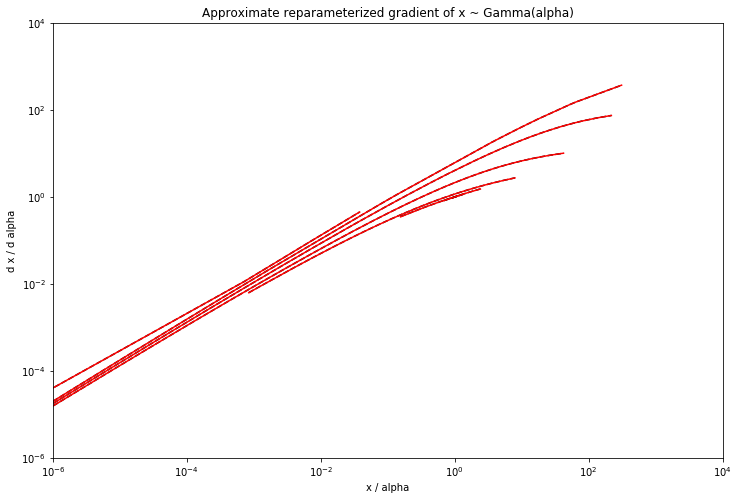

In [19]:
pyplot.figure(figsize=(12, 8))
for alpha in [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]:
    x = scipy.stats.gamma.rvs(np.ones(1000) * alpha)
    x.sort()
    pyplot.plot(x / alpha, np.maximum(1e-8, dx_dalpha(x, alpha)), 'k--')
    pyplot.plot(x / alpha, np.maximum(1e-8, dx_dalpha_final(x, alpha)), 'r-')
pyplot.title('Approximate reparameterized gradient of x ~ Gamma(alpha)')
pyplot.xlabel('x / alpha')
pyplot.ylabel('d x / d alpha')
pyplot.xscale('log')
pyplot.yscale('log')
pyplot.xlim(0.000001, 10000)
pyplot.ylim(0.000001, 10000)
pyplot.legend()
pyplot.show()

Finally, let's print out C code for the coefficients and embed this directly in `aten/src/TH/THRandom.c`.

In [20]:
print('static const double coef_uv[3][8] = {')
for row in coeff.reshape(3, 8):
    print('  {' + ', '.join(map('{:0.8g}'.format, row)) +'},')
print('};')

static const double coef_uv[3][8] = {
  {0.16028008, -0.088064308, 0.019630876, -0.0016920282, 1, 0.36659854, 0.10843863, 0.0066895457},
  {0.521894, 0.16095839, 0.062375971, 0.0023884255, 0.08345772, 0.0073297656, -0.005929905, -0.00093720388},
  {-0.0031143926, -0.012143876, -0.0057656483, -0.00064847251, 0.0087262582, -0.00022820506, 1.8871035e-05, 9.6307967e-06},
};
